### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])

In [4]:
df_original = df.copy()

In [5]:
df = df[df.City=='Barcelona']

### Create Predicted Category for final models (2 categories)

In [6]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [7]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [8]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.859865
Bad     0.140135
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [9]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [11]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*2))
df_balanced_2.shape

(9208, 78)

In [12]:
df_balanced_2.Nationality_Recode.value_counts()

North America          1533
UK & Ireland           1530
Western Europe         1524
Middle east            1523
Eastern Europe         1090
Oceania                 769
Asia & Pacific          634
South/Latin America     219
Sub-Saharian Africa     191
Arab States             100
China                    95
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [13]:
if len(df_balanced_2) > 20000:
    df_model = df_balanced_2.sample(n=20000, random_state=1)
else:
    df_model = df_balanced_2.copy()

df_model.shape

(9208, 78)

In [14]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [15]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [16]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [17]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=1)

In [21]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((7367, 69), (7367,), (1841, 69), (1841,))

## MODELS

### Evaluate Model

In [22]:
import time
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, space_eval

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [24]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [25]:
def evaluate_grid(model, params, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, cv = 5, verbose = verbose)    
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [26]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}',
          '| Precision Test :', f'{precision_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}', 
          '| H Test :', f'{H_score(clf.predict(X_test), y_test):.4f}')
    
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}',
          '| Precision Train:', f'{precision_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}', 
          '| H Train:', f'{H_score(clf.predict(X_train), y_train):.4f}')

In [27]:
def H_score(X_train, y_train):
    acc = accuracy_score(X_train, y_train)
    f1 = f1_score(X_train, y_train, pos_label = "Bad")
    return(2 / ((1/acc)+(1/f1)))

In [28]:
def bayesian(space, X, y, modelo, nevals):
    
    #H = make_scorer(H_score, greater_is_better=True) 
    f1 = make_scorer(f1_score, pos_label = "Bad")
        
    def objective(space):
        
        global best_score
        
        model = modelo(**space)   
        kfold = KFold(n_splits=5, random_state=1985, shuffle=True)
        score = -cross_val_score(model, X, y, cv=kfold, scoring=f1, verbose=False).mean()
        if (score < best_score):
            best_score = score
        return score

    start = time.time()

    best = fmin(
      objective, 
      space = space,
      algo = tpe.suggest, 
      max_evals = nevals,
      trials = Trials())

    print("Hyperopt search took %.2f seconds for 200 candidates" % ((time.time() - start)))
    print("Best score: %.4f " % (-best_score))
    print("Best space: ", space_eval(params, best))
    return(space_eval(params, best))

### KNN

In [29]:
pred_knn = evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)

Accuracy Test : 0.5806 | F1 Test : 0.5816 | Precision Test : 0.5832 | H Test : 0.5811
Accuracy Train: 0.7338 | F1 Train: 0.7360 | Precision Train: 0.7416 | H Train: 0.7349


### Gradient Boosted Trees

In [30]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 
                                                          0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.50]), 
          'n_estimators':      hp.choice('n_estimators', range(1,400)),
          'max_depth':         hp.choice('max_depth',range(1,20)),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train, y_train, GradientBoostingClassifier, 50)
pred_gbt = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:49<00:00,  2.20s/trial, best loss: -0.679210647443276]
Hyperopt search took 110.11 seconds for 200 candidates
Best score: 0.6792 
Best space:  {'learning_rate': 0.001, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 0.16, 'min_samples_split': 0.45, 'n_estimators': 366, 'subsample': 1}
Accuracy Test : 0.6298 | F1 Test : 0.6795 | Precision Test : 0.7850 | H Test : 0.6537
Accuracy Train: 0.6410 | F1 Train: 0.6898 | Precision Train: 0.7980 | H Train: 0.6645


### Random Forest

In [31]:
params = {'bootstrap':         hp.choice('bootstrap',[True, False]),
          'max_depth':         hp.choice('max_depth', range(1, 20)),
          'max_features':      hp.choice('max_features',['auto', 'sqrt']),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'n_estimators':      hp.choice('n_estimators',range(1,400))}

best_score = 1
rf_params = bayesian(params, X_train, y_train, RandomForestClassifier, 50)
pred_rf = evaluate_model(RandomForestClassifier(**rf_params), X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:35<00:00,  3.11s/trial, best loss: -0.6866219738032269]
Hyperopt search took 155.46 seconds for 200 candidates
Best score: 0.6866 
Best space:  {'bootstrap': False, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 0.15000000000000002, 'min_samples_split': 0.86, 'n_estimators': 149}
Accuracy Test : 0.6316 | F1 Test : 0.6793 | Precision Test : 0.7806 | H Test : 0.6546
Accuracy Train: 0.6410 | F1 Train: 0.6886 | Precision Train: 0.7937 | H Train: 0.6639


### XGBoosting

In [32]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                                         0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', range(1,200))}

best_score = 1
xgb_params = bayesian(params, X_train, y_train, xgb.XGBClassifier, 50)
pred_xgb = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:59<00:00,  4.79s/trial, best loss: -0.6811098085458457]
Hyperopt search took 239.74 seconds for 200 candidates
Best score: 0.6811 
Best space:  {'colsample_bytree': 0.64, 'gamma': 0.01, 'learning_rate': 0.0005, 'max_depth': 3, 'min_child_weight': 0.63, 'n_estimators': 129}
Accuracy Test : 0.6323 | F1 Test : 0.6780 | Precision Test : 0.7744 | H Test : 0.6543
Accuracy Train: 0.6496 | F1 Train: 0.6953 | Precision Train: 0.7991 | H Train: 0.6717


### Logistic Regresion

In [33]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train, y_train, LogisticRegression, 50)
pred_log = evaluate_model(LogisticRegression(**log_params), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.95trial/s, best loss: -0.6648246264511]
Hyperopt search took 12.73 seconds for 200 candidates
Best score: 0.6648 
Best space:  {'C': 0.1, 'tol': 0.001}
Accuracy Test : 0.6486 | F1 Test : 0.6604 | Precision Test : 0.6834 | H Test : 0.6544
Accuracy Train: 0.6828 | F1 Train: 0.6930 | Precision Train: 0.7155 | H Train: 0.6878


### Decision Trees

In [34]:
iterations = 100
params = {"max_depth":        hp.choice('max_depth', range(1, 20)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 50)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train, y_train, DecisionTreeClassifier, 150)
pred_tree = evaluate_model(DecisionTreeClassifier(**tree_params), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.96trial/s, best loss: -0.6906955131682846]
Hyperopt search took 25.34 seconds for 200 candidates
Best score: 0.6907 
Best space:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 44, 'min_samples_leaf': 35}
Accuracy Test : 0.6287 | F1 Test : 0.6885 | Precision Test : 0.8208 | H Test : 0.6573
Accuracy Train: 0.6323 | F1 Train: 0.6927 | Precision Train: 0.8284 | H Train: 0.6611


### SVM

In [35]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train, y_train, SVC, 10)
pred_svm = evaluate_model(SVC(**svm_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/trial, best loss: -0.700033957267364]
Hyperopt search took 20.84 seconds for 200 candidates
Best score: 0.7000 
Best space:  {'C': 0.05, 'degree': 3, 'kernel': 'poly'}
Accuracy Test : 0.5911 | F1 Test : 0.6914 | Precision Test : 0.9161 | H Test : 0.6374
Accuracy Train: 0.6160 | F1 Train: 0.7085 | Precision Train: 0.9327 | H Train: 0.6590


### Naive Bayes

In [36]:
params = {"alpha":     hp.choice('alpha', [0.025, 0.05, 0.075, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 
                                           2, 2.5, 5, 10]), 
          "fit_prior": hp.choice('fit_prior', [True, False])}

best_score = 1
nb_params = bayesian(params, X_train, y_train, BernoulliNB, 50)
pred_nb = evaluate_model(BernoulliNB(**nb_params), X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.68trial/s, best loss: -0.6596617412229712]
Hyperopt search took 8.81 seconds for 200 candidates
Best score: 0.6597 
Best space:  {'alpha': 10, 'fit_prior': True}
Accuracy Test : 0.6380 | F1 Test : 0.6485 | Precision Test : 0.6679 | H Test : 0.6432
Accuracy Train: 0.6496 | F1 Train: 0.6614 | Precision Train: 0.6840 | H Train: 0.6555


## CONFIDENCE INTERVAL

In [37]:
model = SVC(**svm_params)

In [38]:
clf = model
clf.fit(X_train, y_train)

SVC(C=0.05, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
pred_f1 = []
pred_ac = []
pred_H = []

for i in range(1000):
    sample = np.random.randint(0, len(X_test), size=len(X_test))
    X_sample = X_test.iloc[sample]
    y_sample = y_test.iloc[sample]
    print(i, end='\r', flush=True)
    pred_f1.append(f1_score(clf.predict(X_sample), y_sample, pos_label='Bad'))
    pred_ac.append(accuracy_score(clf.predict(X_sample), y_sample))
    pred_H.append(H_score(clf.predict(X_sample), y_sample))

(array([  1.,   1.,   0.,   1.,   6.,   6.,  16.,  25.,  40.,  69.,  88.,
         95.,  96., 118., 103.,  92.,  83.,  77.,  35.,  22.,  12.,   8.,
          5.,   0.,   1.]),
 array([0.67077759, 0.67229979, 0.67382198, 0.67534418, 0.67686638,
        0.67838857, 0.67991077, 0.68143296, 0.68295516, 0.68447735,
        0.68599955, 0.68752175, 0.68904394, 0.69056614, 0.69208833,
        0.69361053, 0.69513272, 0.69665492, 0.69817712, 0.69969931,
        0.70122151, 0.7027437 , 0.7042659 , 0.7057881 , 0.70731029,
        0.70883249]),
 <a list of 25 Patch objects>)

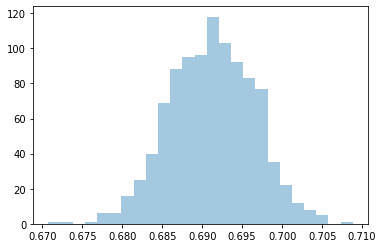

In [43]:
# plt.hist(pred_ac, bins=25, alpha=0.4)
# plt.hist(pred_H, bins=25, alpha=0.4)
plt.hist(pred_f1, bins=25, alpha=0.4)

In [42]:
print('            2.5%    50%  97.5%')
print('H-Score: ',f'{np.percentile(pred_H, 2.5):.4f}',f'{np.percentile(pred_H, 50):.4f}',f'{np.percentile(pred_H, 97.5):.4f}')
print('Accuracy:',f'{np.percentile(pred_ac,2.5):.4f}',f'{np.percentile(pred_ac,50):.4f}',f'{np.percentile(pred_ac,97.5):.4f}')
print('F1-Score:',f'{np.percentile(pred_f1,2.5):.4f}',f'{np.percentile(pred_f1,50):.4f}',f'{np.percentile(pred_f1,97.5):.4f}')

            2.5%    50%  97.5%
H-Score:  0.6272 0.6372 0.6480
Accuracy: 0.5807 0.5911 0.6026
F1-Score: 0.6812 0.6914 0.7013
